In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv('data/train_data.csv')

In [5]:
def dayOfYear(month, day, year):
    daysInMonth = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    dayOfYear = sum(daysInMonth[:int(month)-1]) + int(day)
    if year % 4 == 0 and (year % 100 != 0 or year % 400 == 0) and dayOfYear > 59:
        dayOfYear -= 1
    return dayOfYear

In [6]:
def preprocessing(df):
    
    df['ArrivalDayOfYear'] = df.apply(lambda row: dayOfYear(row['ArrivalMonth'], row['ArrivalDate'], row['ArrivalYear']), axis=1)
    
    df['TotalNights'] = df['NumWeekendNights'] + df['NumWeekNights']

    df['TotalGuests'] = df['NumAdults'] + df['NumChildren']
    
    df['TotalPrice'] = df['AvgRoomPrice'] * df['TotalNights']

    categories = ['MealPlan', 'RoomType', 'MarketSegment', 'BookingStatus']

    dummy_vars = pd.get_dummies(df[categories])
    
    df = pd.concat([df, dummy_vars], axis=1)
    
    df = df.drop(['MealPlan', 'RoomType', 'MarketSegment', 'BookingStatus', 'BookingStatus_Not_Canceled'], axis=1)

    df = df.drop(['ArrivalMonth', 'ArrivalDate', 'ArrivalYear', 'BookingID'], axis=1)

    return df
df = preprocessing(df)

In [7]:
# Define your custom color palette as a list of RGB tuples
custom_palette = ['#A2C799', '#9B81BC']

# Set the custom palette using set_palette()
sns.set_palette(custom_palette)
sns.set(rc={'figure.figsize':(6,6)})

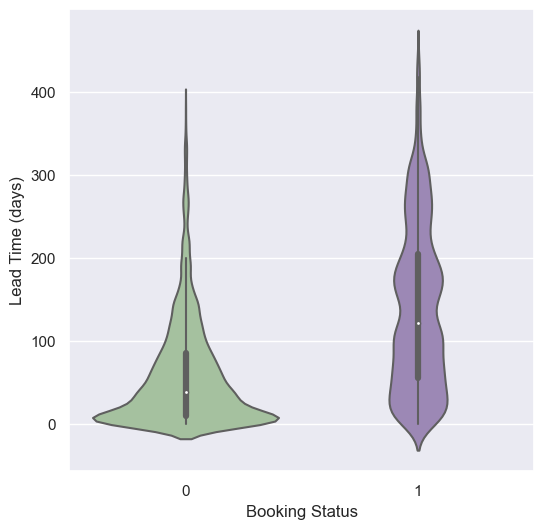

In [8]:
sns.violinplot(x="BookingStatus_Canceled", y="LeadTime", palette=custom_palette, data=df)

plt.gca().set_xlabel("Booking Status")
plt.gca().set_ylabel("Lead Time (days)")

# Show plot
plt.show()


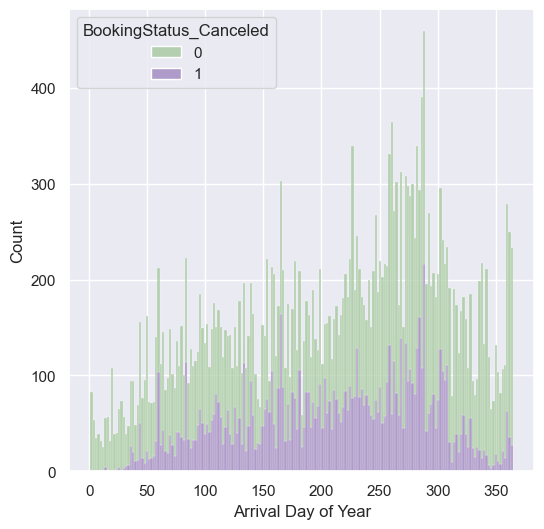

In [9]:
sns.histplot(data=df, bins = 183, x="ArrivalDayOfYear", hue="BookingStatus_Canceled",palette=custom_palette, multiple="stack")

plt.gca().set_xlabel("Arrival Day of Year")
plt.gca().set_ylabel("Count")

# Show plot
plt.show()

In [10]:
top_modes = df['ArrivalDayOfYear'].value_counts().nlargest(5)

# Print top 5 modes
print(top_modes)

289    315
261    255
286    243
226    227
258    200
Name: ArrivalDayOfYear, dtype: int64


In [11]:
df['BookingDayOfYear'] = df['ArrivalDayOfYear'] - df['LeadTime']

In [12]:
df

LeadTime  NumWeekendNights  NumWeekNights  Parking  NumAdults  \
0            10                 0              1        0          1   
1           116                 2              1        0          1   
2            11                 1              2        0          2   
3             3                 0              1        0          2   
4            28                 1              3        0          2   
...         ...               ...            ...      ...        ...   
29015         2                 1              2        0          1   
29016        18                 0              2        0          2   
29017         8                 0              3        0          1   
29018        20                 2              2        0          1   
29019       274                 2              1        0          2   

       NumChildren  RepeatedGuest  NumPrevCancellations  \
0                0              0                     0   
1                0              0                     0   
2                1              0                     0   
3                0              0                     0   
4                0              0                     0   
...            ...            ...                   ...   
29015            0              0                     0   
29016            0              0                     0   
29017            0              0                     0   
29018            0              0                     0   
29019            0              0                     0   

       NumPreviousNonCancelled  AvgRoomPrice  ...  RoomType_Room_Type 5  \
0                            0         95.00  ...                     0   
1                            0         61.00  ...                     0   
2                            0        129.75  ...                     0   
3                            0        152.00  ...                     0   
4                            0         87.00  ...                     0   
...                        ...           ...  ...                   ...   
29015                        0        100.67  ...                     0   
29016                        0        119.00  ...                     0   
29017                        0         65.00  ...                     0   
29018                        0         90.00  ...                     0   
29019                        0         96.50  ...                     0   

       RoomType_Room_Type 6  RoomType_Room_Type 7  MarketSegment_Aviation  \
0                         0                     0                       0   
1                         0                     0                       0   
2                         0                     0                       0   
3                         0                     0                       0   
4                         0                     0                       0   
...                     ...                   ...                     ...   
29015                     0                     0                       0   
29016                     0                     0                       0   
29017                     0                     0                       0   
29018                     0                     0                       0   
29019                     0                     0                       0   

       MarketSegment_Complementary  MarketSegment_Corporate  \
0                                0                        1   
1                                0                        0   
2                                0                        0   
3                                0                        0   
4                                0                        0   
...                            ...                      ...   
29015                            0                        0   
29016                            0                        0   
29017                            0      

In [13]:
df['BookingDayOfYear'] = np.where((df['BookingDayOfYear'] < 0), 366+df['BookingDayOfYear'], df['BookingDayOfYear'])

<Axes: xlabel='BookingDayOfYear', ylabel='Count'>

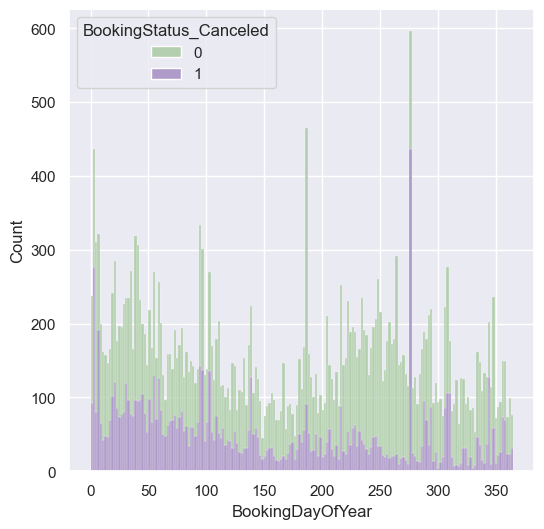

In [14]:
sns.histplot(data=df, bins = 183, x="BookingDayOfYear", hue="BookingStatus_Canceled", palette=custom_palette , multiple="stack")

In [15]:
top_modes = df['BookingDayOfYear'].value_counts().nlargest(5)

# Print top 5 modes
print(top_modes)

276    553
187    418
3      314
96     252
94     251
Name: BookingDayOfYear, dtype: int64


In [16]:

# Select relevant columns and filter by booking status
df = df[['MarketSegment', 'BookingStatus']]
df = df[df['BookingStatus'].isin(['Canceled', 'Not_Canceled'])]

# Compute the percentage of each booking status for each market segment
df_percent = df.groupby(['MarketSegment', 'BookingStatus']).size().reset_index(name='count')
df_percent['percent'] = df_percent.groupby('MarketSegment')['count'].apply(lambda x: 100 * x / float(x.sum()))
df_percent = df_percent.pivot(index='MarketSegment', columns='BookingStatus', values='percent')

# Plot the percentage stacked barplot
sns.set_style('whitegrid')
plt.figure(figsize=(10, 6))
df_percent.plot(kind='bar', stacked=True, color=['#9B81BC', '#A2C799'], edgecolor='black', linewidth=0.5)
plt.title('Booking Status by Market Segment')
plt.xlabel('Market Segment')
plt.ylabel('Percentage')
plt.legend(title='Booking Status')
plt.show()

KeyError: "None of [Index(['MarketSegment', 'BookingStatus'], dtype='object')] are in the [columns]"

<AxesSubplot: xlabel='BookingStatus_Canceled', ylabel='AvgRoomPrice'>

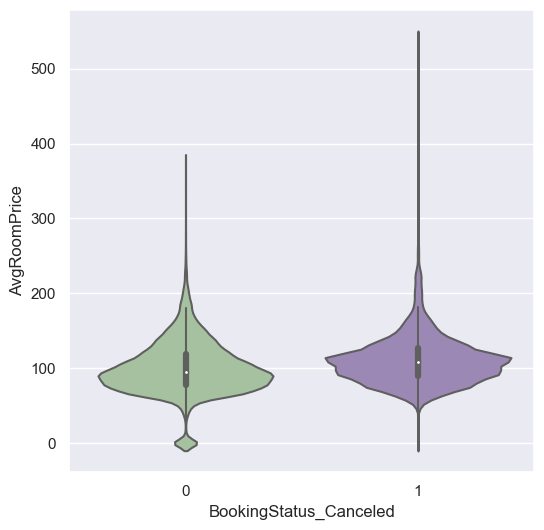

In [ ]:
sns.violinplot(x="BookingStatus_Canceled", y="AvgRoomPrice", palette=custom_palette, data=df)

<AxesSubplot: xlabel='BookingStatus_Canceled', ylabel='TotalPrice'>

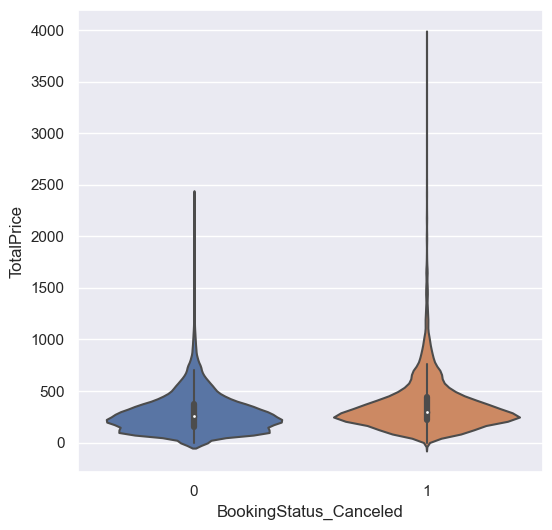

In [ ]:
sns.violinplot(x="BookingStatus_Canceled", y="TotalPrice", data=df)

In [ ]:
df_canceled.ArrivalDayOfYear.mode()

0    289
dtype: int64

BookingStatus_Canceled     0     1
SpecialRequests                   
0                       8976  6838
1                       6933  2165
2                       2975   517
3                        550     0
4                         60     0
5                          6     0


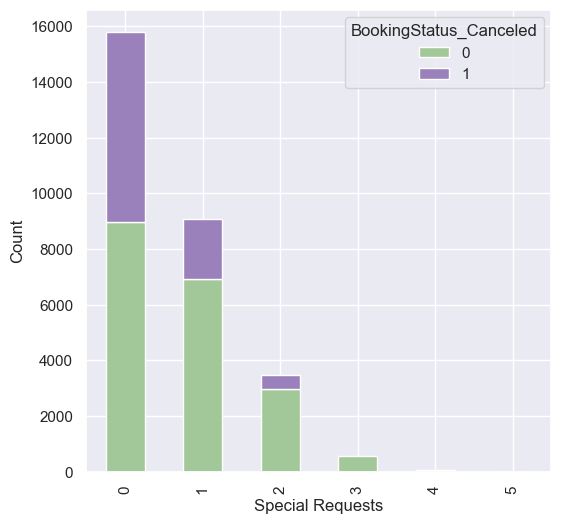

In [ ]:
contingency_table = pd.crosstab(df['SpecialRequests'], df['BookingStatus_Canceled'])

# Print the contingency table
print(contingency_table)

# Visualize the contingency table using a stacked bar chart
contingency_table.plot(kind='bar', stacked=True, color = custom_palette)
plt.title('')
plt.xlabel('Special Requests')
plt.ylabel('Count')
plt.show()

In [ ]:
df['TotalNights'].max()

24

<AxesSubplot: xlabel='TotalNights', ylabel='Count'>

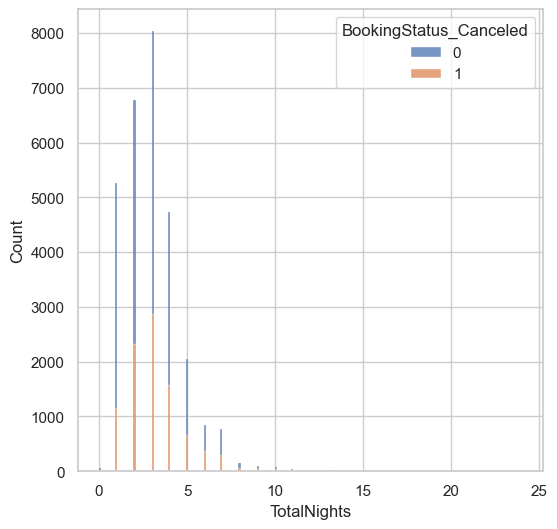

In [ ]:
sns.histplot(data=df, bins = 52, x="TotalNights", hue="BookingStatus_Canceled", multiple="stack")

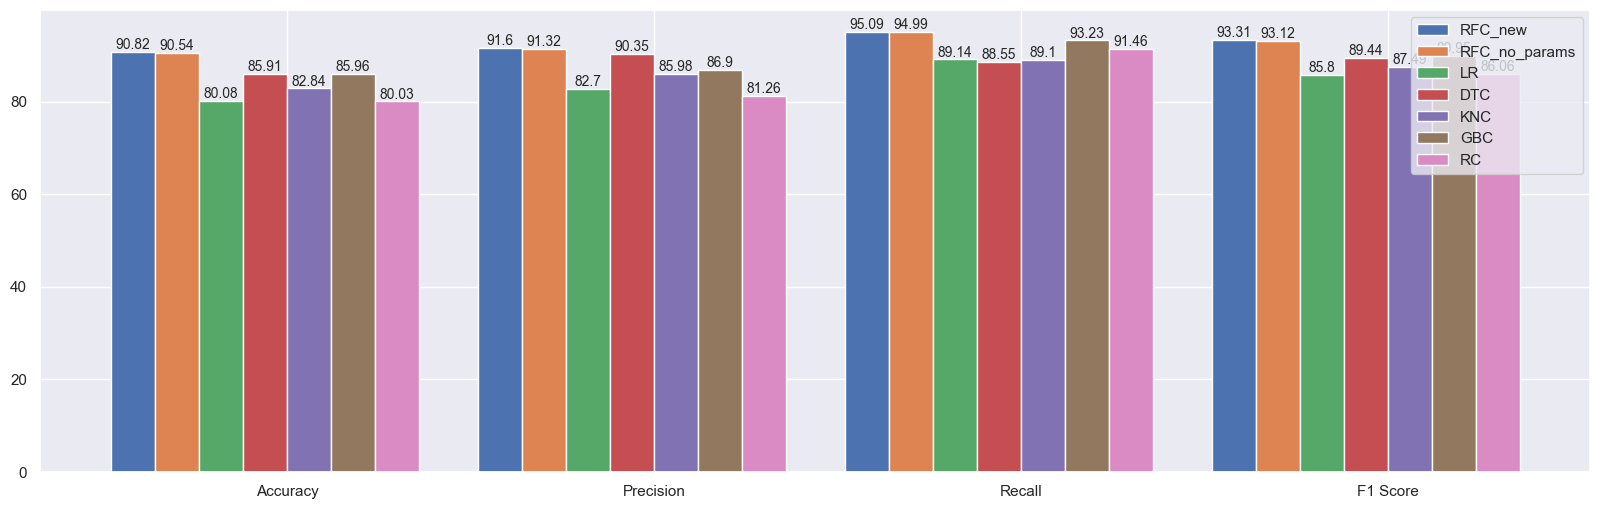

In [ ]:
metrics = {
'RFC_new': [90.82, 91.60, 95.09, 93.31],
'RFC_no_params': [90.54, 91.32, 94.99, 93.12],
'LR': [80.08, 82.70, 89.14, 85.80],
'DTC': [85.91, 90.35, 88.55, 89.44],
'KNC': [82.84, 85.98, 89.10, 87.49],
'GBC': [85.96, 86.90, 93.23, 89.95],
'RC': [80.03, 81.26, 91.46, 86.06]
}

# Create a list of the evaluation metrics
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# Create a list of the model names
model_names = ['RFC_new', 'RFC_no_params', 'LR', 'DTC', 'KNC', 'GBC', 'RC']

# Set the width of each bar
bar_width = 0.12

# Set the x-axis values for the bars
x = np.arange(len(metric_names))

# Create a figure and axes object
fig, ax = plt.subplots(figsize=(20, 6))

# Create a bar for each model and each evaluation metric
for i, model_name in enumerate(model_names):
    bars = ax.bar(x + (i - len(model_names)/2) * bar_width, metrics[model_name], bar_width, label=model_name)

    # Add labels for each bar
    for j, metric_value in enumerate(metrics[model_name]):
        ax.annotate(str(metric_value), xy=(x[j] + (i - len(model_names)/2) * bar_width, metric_value),
                    ha='center', va='bottom', fontsize=10)

# Set the x-axis tick labels
ax.set_xticks(x)
ax.set_xticklabels(metric_names)

# Add a legend
ax.legend()

# Show the plot
plt.show()